In [41]:
import pandas as pd
import numpy as np
import datetime
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
from plotly.subplots import make_subplots
from pandas.plotting import lag_plot
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from source import *


### Importing the data

The imported data below was created from a function that runs through each csv, creates a dataframe for each and then merges them.  Columns are converted to appropriate data types and any mismatches are fixed before merging.  This is important as Leeds City Council changed the formats of the files several times, which led to some differences in column names and potentially data types.

In [42]:
#import merged footfall data
footfalldf_imported = pd.read_csv("../data/footfall_merged.csv.gz",
                                  parse_dates=['Date','DateTime'],
                                  dtype={"BRCYear": int,"BRCWeekNum":int},
                                  index_col=[0])


### Cleaning the data
The next step in the pipeline is to check for duplicates and remove them.  Initial data exploration revealed errors in some of the csv files where individual records had been duplicated.  In some instances, the same records existed in several different files, for example dates in early July appeared towards the end of the June csv.

The cameras don't all come online at the same time, with the last starting on 27th August 2008.  To ensure meaningful comparability, any records before this date have been removed.

Finally, one of the cameras appeared to have moved locations on 31st May 2015 from Commercial Street at Lush to Commercial Street at Sharps.  These are combined and renamed to Commercial Street Combined.

In [43]:
#Pipeline that imports csv files, creates a dataframe and applies cleaning functions
footfalldf = (footfalldf_imported
              .pipe(start_pipeline)
              .pipe(set_start_date, '2008-08-27')
              .pipe(combine_cameras)
              .pipe(check_remove_dup)
              .pipe(create_BRC_MonthNum))



#Useful list for if months ever lost when resampling or plotting.
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

#Dictionary of files that couldn't be imported en-masse due to NaNs in various places
filenames = {1:'Copy%20of%20Monthly%20Data%20Feed%20-%20Oct%202017.csv',
         2:'Copy%20of%20Monthly%20Data%20Feed%20-%20Sept%202017.csv',
         3:'Monthly%20Data%20Feed%20-%20%20Jan%202018.csv',
         4:'Monthly%20Data%20Feed%20-%20Dec%202017.csv',
         5:'Monthly%20Data%20Feed%20-%20Nov%202017.csv',
         6:'Monthly%20Data%20Feed-Feb%202018.csv',
         7:'Monthly%20Data%20Feed-March%202018.csv'}

#Dictionary to hold data frames
data = {}

#Loop through filenames and import troublesome files, tweaking some column names and creating a datetime field.
for k,v in filenames.items():
    df = pd.read_csv(f"../data/lcc_footfall/{v}",
                                  parse_dates=['Date'],
                                  #dtype={"BRCYear": int,"BRCWeekNum":int},
                                  index_col=[0])
    df['FileName'] = v
    df = df.rename(columns={'LocationName':'Location','BRCMonthName':'BRCMonth','InCount':'Count','Date':'DateTime'})
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    data[k] = df

#concats the frames together
frame = pd.concat(data.values())
#drops NaNs from Count field
frame = frame.dropna(subset=['Count'])
#Selects appropriate columns
frame = frame.loc[:,['Location','BRCYear','BRCMonth','Count','BRCWeekNum','FileName','DateTime']].set_index('DateTime')

#Groups by day

print(frame.loc[frame.index == '2017-08-28'],footfalldf.loc[footfalldf.DateTime == '2017-08-28'])

frame = frame.groupby( [pd.Grouper(level='DateTime',freq='D')])['Count'].sum().to_frame()

Footfall hasn't changed when combining cameras
There are 0 duplicates left
                                 Location  BRCYear   BRCMonth  Count  \
DateTime                                                               
2017-08-28            Albion Street North     2017  September  19423   
2017-08-28            Albion Street South     2017  September  14369   
2017-08-28                       Briggate     2017  September  36149   
2017-08-28        Briggate at McDonalds\t     2017  September  10851   
2017-08-28  Commercial Street at Barratts     2017  September  11029   
2017-08-28    Commercial Street at Sharps     2017  September  18271   
2017-08-28              Dortmund Square\t     2017  September  14002   
2017-08-28                        Headrow     2017  September  12629   

            BRCWeekNum                                           FileName  
DateTime                                                                   
2017-08-28          35  Copy%20of%20Monthly%20Data%2

#### Decomposing the series

using both additive and multiplicative decomposition to determine level, trend, seasonality and residuals.

First resample dataframes to daily, weekly and monthly total footfall.

Plot to compare and eyeball what components exist.

In [44]:
#Resample into daily footfall.
day = footfalldf.groupby( [pd.Grouper(key='DateTime',freq='D')])['Count'].sum().to_frame()
#dayfinal = pd.concat([day,frame],verify_integrity=True)
day = day.drop(day[day['Count'] == 0].index)
#Set frequency to daily, creating additional rows for missing values and impute using the 'time' based interpolation
day = day.asfreq('D').dropna()#.replace(0,np.nan).interpolate(method='time')

month = footfalldf.groupby( [pd.Grouper(key='DateTime',freq='M')])['Count'].sum().to_frame()
month = month.drop(month[month['Count'] == 0].index)
month = month.asfreq('M').dropna()#.replace(0,np.nan).interpolate(method='time')

week = footfalldf.groupby( [pd.Grouper(key='DateTime',freq='W')])['Count'].sum().to_frame()
week = week.drop(week[week['Count'] == 0].index)
week = week.asfreq('W').dropna()


In [45]:
fig = make_subplots(rows=3,cols=1)

fig.add_trace(
    go.Scatter(x=day.index,y=day.Count,mode='lines',name='Daily footfall',connectgaps=False),row=1,col=1
)
fig.add_trace(
    go.Scatter(x=week.index,y=week.Count,mode='lines',name='Weekly Footfall'),row=2,col=1
)
fig.add_trace(
    go.Scatter(x=month.index,y=month.Count,mode='lines',name='Monthly Footfall'),row=3,col=1
)

fig.show()

Looks like seasonality is present, there is a general increase from June/July until a peak in December.  The amplitude of this seemed to decrease after the first couple of years, remaining fairly stable until the pandemic when everything went a bit crazy.

Unfortunately there's a bit of missing data, which can be investigated by running the footfall download script and reading the console printouts.  For reference the most recent version is

File Copy%20of%20Monthly%20Data%20Feed%20-%20Oct%202017.csv<br>
File Copy%20of%20Monthly%20Data%20Feed%20-%20Sept%202017.csv<br>
File Monthly%20Data%20Feed%20-%20%20Jan%202018.csv<br>
File Monthly%20Data%20Feed%20-%20Dec%202017.csv<br>
File Monthly%20Data%20Feed%20-%20Nov%202017.csv<br>
File Monthly%20Data%20Feed-Feb%202018.csv<br>
File Monthly%20Data%20Feed-March%202018.csv<br>

Wasn't going to sort these but imputing the missing values didn't really work.  I think all but one are essentially just already aggregated to daily footfall already, so whilst they can't be used for mean hourly counts, they can be integrated into a model with a small bit of cleaning.


Let's have a look at some other plots to understand lag and autocorrelation.

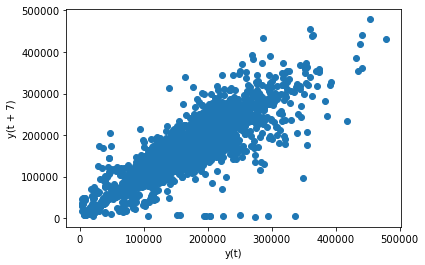

In [46]:
lag_plot(day,lag=7)
pyplot.show()

Looks like we'll need additive decomposition to visualise the components but I'll run a multiplicative model as well to check.  The code below creates dataframes for both containing the observed data, trend, seasonality and residuals.

### Daily footfall

In [47]:
additive = seasonal_decompose(day, model = 'additive',period=365)
multiplicative = seasonal_decompose(day, model = 'multiplicative',freq=365)

result_add = pd.DataFrame(
    {'observed': additive.observed,
    'trend':additive.trend,
         'seasonal':additive.seasonal,
         'residuals':additive.resid}

)

result_multi  = pd.DataFrame(
    {'observed': multiplicative.observed,
              'trend':multiplicative.trend,
         'seasonal':multiplicative.seasonal,
         'residuals':multiplicative.resid
}
)

<ipython-input-47-3ad6c80c118f>:2: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



#### Additive Decomposition

The code below plots the additive decomposition elements

In [48]:
fig = px.line(result_add,facet_row='variable')

fig.update_layout(showlegend=False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Looks like there's no trend until what appears to be the start of lockdown restrictions in Leeds.  There's a clear seasonality which seems to match the observed data.

#### Multiplicative Decomposition

The code below plots the multiplicative decomposition elements

In [49]:
fig = px.line(result_multi,facet_row='variable')

fig.update_layout(showlegend=False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Nothing.  Wonderful.  I'll try both of the above for weekly and monthly frequencies to see how much/little they agree.

### Weekly footfall

In [50]:
additive = seasonal_decompose(week, model = 'additive',period=52)
multiplicative = seasonal_decompose(week, model = 'multiplicative',freq=52)

result_add = pd.DataFrame(
    {'observed': additive.observed,
    'trend':additive.trend,
         'seasonal':additive.seasonal,
         'residuals':additive.resid}

)

result_multi  = pd.DataFrame(
    {'observed': multiplicative.observed,
              'trend':multiplicative.trend,
         'seasonal':multiplicative.seasonal,
         'residuals':multiplicative.resid
}
)

<ipython-input-50-6dddb79b46bb>:2: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



#### Additive Decomposition

The code below plots the additive decomposition elements

In [51]:
fig = px.line(result_add,facet_row='variable')

fig.update_layout(showlegend=False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Looks like there's no trend until what appears to be the start of lockdown restrictions in Leeds.  There's a clear seasonality which seems to match the observed data.

#### Multiplicative Decomposition

The code below plots the multiplicative decomposition elements

In [52]:
fig = px.line(result_multi,facet_row='variable')

fig.update_layout(showlegend=False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

### Monthly footfall

In [53]:
additive = seasonal_decompose(month, model = 'additive',period=12)
multiplicative = seasonal_decompose(month, model = 'multiplicative',freq=12)

result_add = pd.DataFrame(
    {'observed': additive.observed,
    'trend':additive.trend,
         'seasonal':additive.seasonal,
         'residuals':additive.resid}

)

result_multi  = pd.DataFrame(
    {'observed': multiplicative.observed,
              'trend':multiplicative.trend,
         'seasonal':multiplicative.seasonal,
         'residuals':multiplicative.resid
}
)

<ipython-input-53-816a80310d4e>:2: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



#### Additive Decomposition

The code below plots the additive decomposition elements

In [54]:
fig = px.line(result_add,facet_row='variable')

fig.update_layout(showlegend=False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Looks like there's no trend until what appears to be the start of lockdown restrictions in Leeds.  There's a clear seasonality which seems to match the observed data.

#### Multiplicative Decomposition

The code below plots the multiplicative decomposition elements

In [55]:
fig = px.line(result_multi,facet_row='variable')

fig.update_layout(showlegend=False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

They all seem to agree with one another.  The additive decomposition works quite well to identify the sesonality and residuals.

Removing seasonality seems pretty complicated so I might just move onto creating the time lags for the dataset as it is and then come back to it.  Whilst I'm confident I could step through the processes ok, the problem is that with missing data not being imputed, I'm not confident of the process working.

I might just need to use the time imputed function to add in some random crappy values just to get this process to work.  For now I'll just crack on with getting the model set up and doing some evaluation.  Cleaning up the data, imputing values, removing seasonality can all be part of improving it.

Most of this follows the guidance in https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [56]:
#output aggregated files to csv for testing elsewhere
day.to_csv("../data/dailyfootfall.csv")
week.to_csv("../data/weeklyfootfall.csv")
month.to_csv("../data/monthlyfootfall.csv")


#### Define functions for random forest model

In [65]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols,names = list(),list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

def movecol(df, cols_to_move=[], ref_col='', place='After'):

    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]

    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]

    return(df[seg1 + seg2 + seg3])

# load the dataset
series = day.copy(deep=True)
values = series.values
# transform the time series data into supervised learning
data = create_lockdown_var(series_to_supervised(series, n_in=6))
cols_to_move = [col for col in data.iloc[:,0:7]]
ref_col = [col for col in data.iloc[:,-1:]][0]
data = movecol(data,
             cols_to_move=cols_to_move,
             ref_col=ref_col,
             place='After')


In [58]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

TypeError: '(slice(None, -12, None), slice(None, None, None))' is an invalid key